# Collaborative Recommendation

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import pandas as pd
import numpy as np
import random

# fix seeds
random.seed(42)
np.random.seed(42)

## Load data

In [3]:
data = pd.read_csv("../data/cd_and_vinyl/dense_subset.csv")
data_items = pd.read_json("../data/cd_and_vinyl/meta_CDs_and_Vinyl.jsonl", lines=True)

## Sample User and Items

In [47]:
sample_user = (
    data.query(f"user_id == '{data.sample(1, random_state=45)['user_id'].values[0]}'")
    .drop_duplicates()
    .drop(columns=["images", "helpful_vote", "verified_purchase"])
)

In [48]:
items_user = data_items.query("parent_asin in @sample_user['parent_asin'].values").drop(
    columns=["features", "images", "videos", "bought_together", "subtitle", "author"]
)

## Agents

In [49]:
# from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# ollama = ChatOllama(model="phi3:3.8b")
openai = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

In [51]:
# Train / Test
liked_items = sample_user.query("rating > 3")
liked_items_train = liked_items.sample(2, random_state=42)
liked_items_test = liked_items.drop(liked_items_train.index).sample(2, random_state=42)

disliked_items = sample_user.query("rating < 3")
disliked_items_train = disliked_items.sample(2, random_state=42)
disliked_items_test = disliked_items.drop(disliked_items_train.index).sample(
    2, random_state=42
)

In [52]:
liked_items_train = liked_items_train.merge(items_user, on="parent_asin")
liked_items_test = liked_items_test.merge(items_user, on="parent_asin")

disliked_items_train = disliked_items_train.merge(items_user, on="parent_asin")
disliked_items_test = disliked_items_test.merge(items_user, on="parent_asin")

In [53]:
liked_items_test

,rating,title_x,text,asin,parent_asin,user_id,timestamp,main_category,title_y,average_rating,rating_number,description,price,store,categories,details
0,5.0,To Fred Dursts fan,YOU SUCK! If you knew anything about metal you...,B0002EXH5O,B0002EXH5O,AGDX6GPEK772FFKOWYJVJRLKWTRQ,1121869919000,Digital Music,Rust In Peace,4.8,2861,[This re-issue features four previously unrele...,12.51,Megadeth Format: Audio CD,"[CDs & Vinyl, Rock, Progressive, Progressive M...","{'Is Discontinued By Manufacturer': 'No', 'Pro..."
1,5.0,Rock is forever in debt to Pearl Jam,Why? Well it should be obvious. From '89 to '9...,B0000027RL,B0000027RL,AGDX6GPEK772FFKOWYJVJRLKWTRQ,1125577991000,Digital Music,Ten,4.8,9044,"[Product description, Huge debut album from 19...",8.98,Pearl Jam Format: Audio CD,"[CDs & Vinyl, Pop, Adult Alternative]","{'Is Discontinued By Manufacturer': 'No', 'Lan..."


In [54]:
disliked_items_train

,rating,title_x,text,asin,parent_asin,user_id,timestamp,main_category,title_y,average_rating,rating_number,description,price,store,categories,details
0,1.0,Now that the Green Day fad is finally starting...,"I told you, just read any 1 star reviews and y...",B000002MP2,B000002MP2,AGDX6GPEK772FFKOWYJVJRLKWTRQ,1128113818000,Digital Music,Dookie,4.8,3986,"[Product Description, Certified at 10 million ...",9.0,Green Day Format: Audio CD,"[CDs & Vinyl, Indie & Alternative, Alternative...","{'Is Discontinued By Manufacturer': 'No', 'Lan..."
1,1.0,Rap should take out a restraining order agains...,"So, here it is. The follow up to that damned t...",B0007P3582,B0007P3582,AGDX6GPEK772FFKOWYJVJRLKWTRQ,1121691341000,Digital Music,The Massacre Explicit Lyrics,4.5,1493,"[Product Description, 50 Cent's highly anticip...",10.98,50 Cent Format: Audio CD,"[CDs & Vinyl, Rap & Hip-Hop, East Coast]","{'Is Discontinued By Manufacturer': 'No', 'Pac..."


In [55]:
# from langchain_core.prompts import PromptTemplate

PROMPT_USER_ITEM = """
Item: {title_item}
Item category: {item_category}
Description: {description}
Price: ${price}
Store: {store}
Categories: {categories}
User rating: {rating}
User comment title: {title_comment}
User comment: {text_comment}
"""

PROMPT_ITEM = """
Item: {title_item}
Item category: {item_category}
Description: {description}
Price: ${price}
Store: {store}
Categories: {categories}
"""


def encode_item(item):
    title_item = item["title_y"]
    item_category = item["main_category"]
    description = " ".join(item["description"])
    price = item["price"]
    store = item["store"]
    categories = item["categories"]

    return {
        "title_item": title_item,
        "item_category": item_category,
        "description": description,
        "price": price,
        "store": store,
        "categories": categories,
    }


def encode_item_format(item):
    item_info = encode_item(item)

    return PROMPT_ITEM.format(
        title_item=item_info["title_item"],
        item_category=item_info["item_category"],
        description=item_info["description"],
        price=item_info["price"],
        store=item_info["store"],
        categories=item_info["categories"],
    )


def encode_user(user):
    title_comment = user["title_x"]
    text_comment = user["text"]
    rating = user["rating"]

    return {
        "title_comment": title_comment,
        "text_comment": text_comment,
        "rating": rating,
    }


def encode_item_user_format(item_user):
    item_info = encode_item(item_user)
    user_info = encode_user(item_user)

    return PROMPT_USER_ITEM.format(
        title_item=item_info["title_item"],
        item_category=item_info["item_category"],
        description=item_info["description"],
        price=item_info["price"],
        store=item_info["store"],
        categories=item_info["categories"],
        rating=user_info["rating"],
        title_comment=user_info["title_comment"],
        text_comment=user_info["text_comment"],
    )

In [57]:
liked_items_train["encoded_item_user"] = liked_items_train.apply(
    lambda row: encode_item_user_format(row), axis=1
)
disliked_items_train["encoded_item_user"] = disliked_items_train.apply(
    lambda row: encode_item_user_format(row), axis=1
)

liked_items_test["encoded_item"] = liked_items_test.apply(
    lambda row: encode_item_format(row), axis=1
)
disliked_items_test["encoded_item"] = disliked_items_test.apply(
    lambda row: encode_item_format(row), axis=1
)

In [58]:
liked_items_train_formatted = "\n".join(
    [
        f"ITEM {i}:{item}"
        for i, item in list(enumerate(liked_items_train["encoded_item_user"].values))
    ]
)

disliked_items_train_formatted = "\n".join(
    [
        f"ITEM {i}:{item}"
        for i, item in list(enumerate(disliked_items_train["encoded_item_user"].values))
    ]
)

In [59]:
print(liked_items_train_formatted)

ITEM 0:
Item: In Utero       Explicit Lyrics
Item category: Digital Music
Description: Product description NIRVANA - IN UTERO We receive various CDs from the radio cores that we remanufacture. As a result, we are are now selling them! Our CDs are professionally resurfaced and are guaranteed to work or your money back! These listings are for the disc only and do not come with the case, album art, or inserts. If you have any questions about the CDs, please do not hesitate to get in touch. Amazon.com Overwhelmed by sudden success, Nirvana promised to take a harsher, more abrasive route on their second major-label release. Enlisting Chicago-based noise maven Steve Albini (of Big Black fame), Kurt Cobain and company succeeded in producing a record that was violent, disillusioned, and deeply moving. Every song reads like a commentary on the cost of fame ("Serve the Servants") and the unhealthy relationship between performer and fan ("Milk It"). Of course, they might all simply be about Court

In [60]:
print(disliked_items_train_formatted)

ITEM 0:
Item: Dookie
Item category: Digital Music
Description: Product Description Certified at 10 million units by the RIAA. (2/01) Amazon.com Take one part Ramones, one part Buzzcocks, and one part Husker Du, and you've got the basic foundation of Green Day, a punky, witty, melodic San Francisco Bay area trio who became overnight stars in 1994 when this album, their third overall release and major label debut, catapulted them to the top of the pop charts. Led by guitarist/vocalist Billie Joe Armstrong and their secret weapon, powerhouse drummer Tre Cool, Green Day put '70s and '80s punk in a compact '90s package with songs like "Longview," "Basket Case," "Pulling Teeth," and the hit semi-ballad, "When I Come Around." One the few modern alternative rock bands with a bona fide sense of humor. --Billy Altman
Price: $9.0
Store: Green Day   Format: Audio CD
Categories: ['CDs & Vinyl', 'Indie & Alternative', 'Alternative Rock']
User rating: 1.0
User comment title: Now that the Green Day fa

## Collaborative Recommendation

Using [supervisor architecture](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)

In [78]:
from langgraph.graph import START, END, StateGraph

from typing_extensions import List, TypedDict, Annotated
from operator import add


class State(TypedDict):

    transcription: str

    messages: Annotated[List[str], add]


def user_agent(state: State):

    return {"messages": ["user!"]}


def item_agent(state: State):

    return {"messages": ["item!"]}


def supervisor(state: State):

    return {"messages": ["supervisor"]}


def supervisor_followup(state: State):
    if state["transcription"] == "item":
        return "item"
    elif state["transcription"] == "user":
        return "user"
    return "END"


graph_builder = StateGraph(State)


# Nodes


graph_builder.add_node("user_agent", item_agent)


graph_builder.add_node("item_agent", user_agent)

graph_builder.add_node("supervisor", supervisor)


# Edges


graph_builder.set_entry_point("supervisor")

graph_builder.add_conditional_edges(
    "supervisor",
    supervisor_followup,
)


graph_builder.add_edge("user_agent", "supervisor")

graph_builder.add_edge("item_agent", "supervisor")

graph = graph_builder.compile()

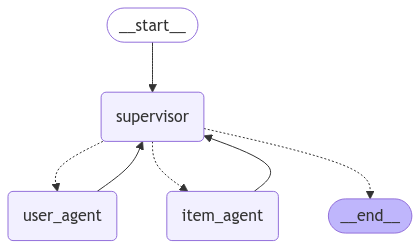

In [79]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from pydantic import BaseModel


class Answer(BaseModel):
    explanation: str
    score: int


PROMPT_USER = """ 
You are a user in a marketplace. Given the following context about items you have interacted with, consider your score to predict if you like or dislike the new itens.
Your answer will be an JSON with two fields: 'explanation' and 'score'. explanation will be a concise rationale about your decision and score will be a integer from 1 to 5, where 1 is dislike and 5 is like.
Don't assume anything about the user that can't be inferred from the context.
Items who you liked:
{liked_items}

Items who you disliked:
{disliked_items}

New item:
{new_items}

Answer:
"""

prompt = PROMPT_USER.format(
    liked_items=liked_items_train_formatted,
    disliked_items=disliked_items_train_formatted,
    new_items=disliked_items_test["encoded_item"].values[0],
)

## Inference

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

len(tokenizer.encode(prompt))

2512

In [ ]:
structured_llm = openai.with_structured_output(Answer, method="json_mode")
answer = structured_llm.invoke(prompt)

In [ ]:
print("Explanation:", answer.explanation)
print("Score:", answer.score)

Explanation: Based on your previous interactions, you have shown a strong preference for heavy metal and hard rock music, as evidenced by your positive ratings for Disturbed and Megadeth. Nickelback, while popular, is often viewed as more mainstream and less heavy than the bands you liked. Given your dislike for rap and pop music, it's likely that you may not appreciate Nickelback's sound as much as the heavier genres you prefer.
Score: 2


## Evaluation

Evaluation comparasion with sample x no sample

In [ ]:
from typing import List

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# warning level
import warnings

warnings.filterwarnings("ignore")


def compute_metrics(y_true: List[int], y_pred: List[int]):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mae": mae,
        "mse": mse,
    }